In [2]:
#0) Setup (install + imports)
%pip -q install -U scikit-image tqdm

import os, io, json, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection._search import ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    f1_score, precision_recall_fscore_support, accuracy_score,
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)

from skimage import io as skio, color as skcolor, transform, exposure, util, filters
from skimage.feature import hog, local_binary_pattern

np.random.seed(42)
SEED = 42
IMG_SIZE = (224, 224)
OUTDIR = "/root/"
os.makedirs(OUTDIR, exist_ok=True)

Note: you may need to restart the kernel to use updated packages.


In [4]:
DATA_ROOT = "Parasite Data Set"  # set to the folder that directly contains the 10 class folders
assert os.path.isdir(DATA_ROOT), f"Path not found: {DATA_ROOT}"
print("DATA_ROOT =", DATA_ROOT)


DATA_ROOT = Parasite Data Set


In [5]:
#2) Load paths, normalize labels (merge magnifications), sanity check
def normalize_folder_to_label(folder: str) -> str:
    base = folder.split('_')[0] if '_' in folder else folder
    m = {
        "rbcs": "RBCs", "leukocyte": "Leukocyte", "babesia": "Babesia",
        "leishmania": "Leishmania", "plasmodium": "Plasmodium",
        "toxoplasma": "Toxoplasma", "trichomonad": "Trichomonad",
        "trypanosome": "Trypanosome"
    }
    base_l = base.lower()
    for k, v in m.items():
        if base_l.startswith(k): return v
    return base

def collect_paths(root):
    X, y = [], []
    for dp, _, fn in os.walk(root):
        if dp == root: 
            continue
        folder = os.path.basename(dp)
        label = normalize_folder_to_label(folder)
        for f in fn:
            if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
                X.append(os.path.join(dp, f)); y.append(label)
    order = np.argsort(np.array(X))
    X = np.array(X)[order]; y = np.array(y)[order]
    classes = sorted(set(y.tolist()))
    return X, y, classes

X_paths, y_str, classes_str = collect_paths(DATA_ROOT)
print("Found classes & counts:", Counter(y_str))
print("Num classes:", len(classes_str), "→", classes_str)
assert len(classes_str) >= 5, "Too few classes found — check DATA_ROOT."

Found classes & counts: Counter({'Trichomonad': 10134, 'RBCs': 8995, 'Toxoplasma': 6691, 'Leishmania': 2701, 'Trypanosome': 2385, 'Leukocyte': 1376, 'Babesia': 1173, 'Plasmodium': 843, '.ipynb': 5})
Num classes: 9 → ['.ipynb', 'Babesia', 'Leishmania', 'Leukocyte', 'Plasmodium', 'RBCs', 'Toxoplasma', 'Trichomonad', 'Trypanosome']


In [6]:
#3) Encode labels, stratified 60/20/20 split (all classes guaranteed)
le = LabelEncoder().fit(y_str)
y_all = le.transform(y_str)             # ints 0..C-1
classes_str = list(le.classes_)         # ordered names

def stratified_60_20_20(X, y, seed=42, max_tries=50):
    rng = np.random.RandomState(seed)
    allc = set(y)
    for _ in range(max_tries):
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=rng.randint(1, 10**6))
        trval_idx, te_idx = next(sss1.split(X, y))
        X_trval, y_trval = X[trval_idx], y[trval_idx]
        X_test,  y_test  = X[te_idx],   y[te_idx]

        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=rng.randint(1, 10**6))
        tr_idx, va_idx = next(sss2.split(X_trval, y_trval))
        X_train, y_train = X_trval[tr_idx], y_trval[tr_idx]
        X_val,   y_val   = X_trval[va_idx], y_trval[va_idx]

        if set(y_train)==allc and set(y_val)==allc and set(y_test)==allc:
            return X_train, y_train, X_val, y_val, X_test, y_test
    raise RuntimeError("Could not make splits with all classes present.")

X_train, y_train, X_val, y_val, X_test, y_test = stratified_60_20_20(X_paths, y_all, seed=SEED)
print("Split sizes:", len(X_train), len(X_val), len(X_test))

Split sizes: 20581 6861 6861


In [7]:
#4) Feature extraction — Color + multi-scale HOG/LBP (LBP on uint8)
def preprocess_gray_rgb(img):
    # ensure RGB and GRAY versions at target size
    if img.ndim == 2:
        img_gray = img
        img_rgb  = np.stack([img,img,img], axis=-1)
    else:
        if img.shape[-1] == 4:
            img = img[...,:3]  # drop alpha if present
        img_rgb  = img
        img_gray = skcolor.rgb2gray(img_rgb)

    img_gray = transform.resize(img_gray, IMG_SIZE, anti_aliasing=True)
    img_gray = exposure.equalize_adapthist(img_gray, clip_limit=0.02)  # CLAHE on luminance
    img_rgb  = transform.resize(img_rgb, (*IMG_SIZE, 3), anti_aliasing=True)
    return img_gray, img_rgb

def extract_features(img):
    img_gray, img_rgb = preprocess_gray_rgb(img)

    # --- COLOR in HSV (16 bins each) ---
    hsv = skcolor.rgb2hsv(img_rgb)
    H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]
    def nhist(a, bins=16):
        h, _ = np.histogram(a.ravel(), bins=bins, range=(0,1), density=True); return h
    col = np.hstack([nhist(H), nhist(S), nhist(V)])

    # --- HOG at two scales on gray ---
    h1 = hog(img_gray, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9, feature_vector=True)
    h2 = hog(img_gray, pixels_per_cell=(24,24), cells_per_block=(2,2), orientations=9, feature_vector=True)

    # --- LBP (uniform) two radii on uint8 gray ---
    g8 = (np.clip(img_gray,0,1)*255).astype('uint8')
    lbp1 = local_binary_pattern(g8, P=8,  R=1, method="uniform");  hist1, _ = np.histogram(lbp1.ravel(), bins=np.arange(0, 8+2+1),  range=(0, 8+2),  density=True)
    lbp2 = local_binary_pattern(g8, P=16, R=2, method="uniform");  hist2, _ = np.histogram(lbp2.ravel(), bins=np.arange(0,16+2+1),  range=(0,16+2), density=True)

    stats = [img_gray.mean(), img_gray.std()]
    return np.hstack([col, h1, h2, hist1, hist2, stats])

def feats_from_paths(paths, tform=None):
    F = []
    for p in tqdm(paths, desc="Features"):
        try:
            im = skio.imread(p)
            if tform is None:
                F.append(extract_features(im))
            else:
                # apply degradation tform to gray only; reuse color from preprocessed RGB
                img_gray, img_rgb = preprocess_gray_rgb(im)
                gray_d = tform(img_gray)
                hsv = skcolor.rgb2hsv(img_rgb)
                H,S,V = hsv[...,0], hsv[...,1], hsv[...,2]
                def nhist(a, bins=16):
                    h,_ = np.histogram(a.ravel(), bins=bins, range=(0,1), density=True); return h
                col = np.hstack([nhist(H), nhist(S), nhist(V)])
                h1 = hog(gray_d, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9, feature_vector=True)
                h2 = hog(gray_d, pixels_per_cell=(24,24), cells_per_block=(2,2), orientations=9, feature_vector=True)
                g8 = (np.clip(gray_d,0,1)*255).astype('uint8')
                lbp1 = local_binary_pattern(g8,8,1,"uniform");  hist1,_=np.histogram(lbp1.ravel(), bins=np.arange(0,11), range=(0,10), density=True)
                lbp2 = local_binary_pattern(g8,16,2,"uniform"); hist2,_=np.histogram(lbp2.ravel(), bins=np.arange(0,19), range=(0,18), density=True)
                stats = [gray_d.mean(), gray_d.std()]
                F.append(np.hstack([col,h1,h2,hist1,hist2,stats]))
        except Exception:
            pass
    return np.array(F)

In [9]:
#5) Balance the training set (undersample large classes)
def balance_indices(labels, max_per_class=3000, seed=42):
    rng = np.random.RandomState(seed)
    byc = defaultdict(list)
    for i,lab in enumerate(labels): byc[lab].append(i)
    keep = []
    for c,idxs in byc.items():
        if len(idxs) > max_per_class:
            keep.extend(rng.choice(idxs, size=max_per_class, replace=False))
        else:
            keep.extend(idxs)
    return np.array(sorted(keep))

keep_idx = balance_indices(y_train, max_per_class=3000)
X_train_bal, y_train_bal = X_train[keep_idx], y_train[keep_idx]
print("Train balanced:", len(y_train), "→", len(y_train_bal))

Train balanced: 20581 → 14089


In [10]:
#6) Extract features (balanced train, full val/test)
Xtr = feats_from_paths(X_train_bal); ytr = y_train_bal[:len(Xtr)]
Xva = feats_from_paths(X_val);       yva = y_val[:len(Xva)]
Xte = feats_from_paths(X_test);      yte = y_test[:len(Xte)]

print("Feature shapes:", Xtr.shape, Xva.shape, Xte.shape)
print("[TRAIN] per-class (encoded):", Counter(ytr))
print("[VAL]   per-class (encoded):",   Counter(yva))
print("[TEST]  per-class (encoded):",   Counter(yte))

Features: 100%|██████████| 6861/6861 [08:57<00:00, 12.77it/s]


Feature shapes: (14089, 8466) (6861, 8466) (6861, 8466)
[TRAIN] per-class (encoded): Counter({6: 3000, 5: 3000, 7: 3000, 2: 1621, 8: 1431, 3: 826, 1: 703, 4: 505, 0: 3})
[VAL]   per-class (encoded): Counter({7: 2027, 5: 1799, 6: 1338, 2: 540, 8: 477, 3: 275, 1: 235, 4: 169, 0: 1})
[TEST]  per-class (encoded): Counter({7: 2027, 5: 1799, 6: 1338, 2: 540, 8: 477, 3: 275, 1: 235, 4: 169, 0: 1})


In [11]:
#7) Train KNN with PCA and a progress bar (macro-F1 CV)
param_grid = {
    "knn__n_neighbors": [5,9,15,25,35],
    "knn__metric": ["euclidean","cosine"],
    "knn__weights": ["distance","uniform"],
    # You can also try PCA energy options:
    # "pca__n_components": [0.90, 0.95]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

params_list = list(ParameterGrid(param_grid))
print(f"Total combinations: {len(params_list)} × {cv.get_n_splits()} folds")

best_params, best_score = None, -1.0
for i, params in enumerate(tqdm(params_list, desc="Grid", unit="cfg")):
    # Build model for this config
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=True)),
        ("pca", PCA(n_components=0.95, svd_solver="full", random_state=SEED)),
        ("knn", KNeighborsClassifier(
            n_neighbors=params["knn__n_neighbors"],
            metric=params["knn__metric"],
            weights=params["knn__weights"],
            n_jobs=-1
        ))
    ])
    # If you add pca__n_components in the grid, set it here:
    # model.set_params(pca__n_components=params["pca__n_components"])

    scores=[]
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        model.fit(Xtr[tr_idx], ytr[tr_idx])
        pred = model.predict(Xtr[va_idx])
        scores.append(f1_score(ytr[va_idx], pred, average="macro"))
    mean_f1 = float(np.mean(scores))
    tqdm.write(f"[{i+1}/{len(params_list)}] {params} → CV macro-F1={mean_f1:.4f}")
    if mean_f1 > best_score:
        best_score, best_params = mean_f1, params

print("Best (CV macro-F1):", round(best_score,4), "with", best_params)

# Final fit on all training
best = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("pca", PCA(n_components=0.95, svd_solver="full", random_state=SEED)),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_params["knn__n_neighbors"],
        metric=best_params["knn__metric"],
        weights=best_params["knn__weights"],
        n_jobs=-1
    ))
])
best.fit(Xtr, ytr)

# Save the model for reuse
import joblib
joblib.dump(best, f"{OUTDIR}/best_knn.pkl")
print("Saved model to:", f"{OUTDIR}/best_knn.pkl")

Total combinations: 20 × 5 folds


Grid:   0%|          | 0/20 [00:00<?, ?cfg/s]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
Grid:   5%|▌         | 1/20 [12:22<3:54:59, 742.07s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[1/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'distance'} → CV macro-F1=0.3120


Grid:  10%|█         | 2/20 [24:41<3:42:07, 740.39s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[2/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'} → CV macro-F1=0.3006


Grid:  15%|█▌        | 3/20 [36:57<3:29:17, 738.66s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[3/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'distance'} → CV macro-F1=0.2963


Grid:  20%|██        | 4/20 [49:13<3:16:42, 737.63s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[4/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'} → CV macro-F1=0.2834


Grid:  25%|██▌       | 5/20 [1:01:31<3:04:24, 737.62s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[5/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'distance'} → CV macro-F1=0.2853


Grid:  30%|███       | 6/20 [1:13:50<2:52:12, 738.03s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[6/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'} → CV macro-F1=0.2752


Grid:  35%|███▌      | 7/20 [1:26:08<2:39:52, 737.92s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[7/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 25, 'knn__weights': 'distance'} → CV macro-F1=0.2709


Grid:  40%|████      | 8/20 [1:38:25<2:27:33, 737.75s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[8/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'} → CV macro-F1=0.2559


Grid:  45%|████▌     | 9/20 [1:50:44<2:15:19, 738.14s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[9/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 35, 'knn__weights': 'distance'} → CV macro-F1=0.2608


Grid:  50%|█████     | 10/20 [2:03:03<2:03:04, 738.41s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[10/20] {'knn__metric': 'euclidean', 'knn__n_neighbors': 35, 'knn__weights': 'uniform'} → CV macro-F1=0.2461


Grid:  55%|█████▌    | 11/20 [2:15:25<1:50:54, 739.40s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[11/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 5, 'knn__weights': 'distance'} → CV macro-F1=0.5989


Grid:  60%|██████    | 12/20 [2:27:46<1:38:41, 740.14s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[12/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'} → CV macro-F1=0.5737


Grid:  65%|██████▌   | 13/20 [2:40:08<1:26:23, 740.49s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[13/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 9, 'knn__weights': 'distance'} → CV macro-F1=0.5634


Grid:  70%|███████   | 14/20 [2:52:29<1:14:04, 740.79s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[14/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 9, 'knn__weights': 'uniform'} → CV macro-F1=0.5435


Grid:  75%|███████▌  | 15/20 [3:04:51<1:01:45, 741.12s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[15/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 15, 'knn__weights': 'distance'} → CV macro-F1=0.5538


Grid:  80%|████████  | 16/20 [3:17:14<49:26, 741.66s/cfg]  /opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[16/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'} → CV macro-F1=0.5360


Grid:  85%|████████▌ | 17/20 [3:29:33<37:02, 740.96s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[17/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 25, 'knn__weights': 'distance'} → CV macro-F1=0.5391


Grid:  90%|█████████ | 18/20 [3:41:56<24:42, 741.31s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[18/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'} → CV macro-F1=0.5233


Grid:  95%|█████████▌| 19/20 [3:54:18<12:21, 741.65s/cfg]/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


[19/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 35, 'knn__weights': 'distance'} → CV macro-F1=0.5267


Grid: 100%|██████████| 20/20 [4:06:40<00:00, 740.02s/cfg]


[20/20] {'knn__metric': 'cosine', 'knn__n_neighbors': 35, 'knn__weights': 'uniform'} → CV macro-F1=0.5125
Best (CV macro-F1): 0.5989 with {'knn__metric': 'cosine', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


PermissionError: [Errno 13] Permission denied: '/root//best_knn.pkl'

In [12]:
#8) Predict with a percentage progress bar, compute & save metrics
def predict_with_progress(model, X, batch=500):
    preds = []
    for i in tqdm(range(0, len(X), batch), desc="Predicting", unit="batch"):
        preds.extend(model.predict(X[i:i+batch]))
    return np.array(preds)

print("🔹 Running predictions with progress...")
yva_hat = predict_with_progress(best, Xva, batch=500)
yte_hat = predict_with_progress(best, Xte, batch=500)

C = len(classes_str)
val_macro = f1_score(yva, yva_hat, average="macro")
test_macro = f1_score(yte, yte_hat, average="macro")
prec, rec, f1s, _ = precision_recall_fscore_support(yte, yte_hat, labels=range(C), zero_division=0)
acc = accuracy_score(yte, yte_hat)
cm = confusion_matrix(yte, yte_hat, labels=range(C))

print(f"\nVal macro-F1: {val_macro:.4f} | Test macro-F1: {test_macro:.4f} | Test Acc: {acc:.4f}")

yte_true_str = [classes_str[i] for i in yte]
yte_pred_str = [classes_str[i] for i in yte_hat]
print("\nClassification Report:\n")
print(classification_report(yte_true_str, yte_pred_str, labels=classes_str, target_names=classes_str, zero_division=0))

# Save artifacts (JSON-safe best params)
knn = best.named_steps["knn"]
knn_params = {k: v for k, v in knn.get_params(deep=False).items() if isinstance(v, (int,float,str,bool))}

np.savetxt(f"{OUTDIR}/confusion_matrix.csv", cm, fmt="%d", delimiter=",")
with open(f"{OUTDIR}/test_metrics.json","w") as f:
    json.dump({
        "best_params": knn_params,
        "val_macroF1": float(val_macro),
        "test_macroF1": float(test_macro),
        "accuracy": float(acc),
        "per_class": {classes_str[i]: {
            "precision": float(prec[i]), "recall": float(rec[i]), "f1": float(f1s[i])
        } for i in range(C)},
        "classes": classes_str
    }, f, indent=2)
print(" Metrics saved to:", OUTDIR)

🔹 Running predictions with progress...


Predicting: 100%|██████████| 14/14 [00:07<00:00,  1.82batch/s]


Val macro-F1: 0.5343 | Test macro-F1: 0.6412 | Test Acc: 0.6487

Classification Report:

              precision    recall  f1-score   support

      .ipynb       1.00      1.00      1.00         1
     Babesia       0.53      0.79      0.63       235
  Leishmania       0.24      0.89      0.38       540
   Leukocyte       0.94      0.76      0.84       275
  Plasmodium       0.45      0.18      0.25       169
        RBCs       0.96      0.67      0.79      1799
  Toxoplasma       0.92      0.73      0.81      1338
 Trichomonad       0.78      0.59      0.67      2027
 Trypanosome       0.48      0.34      0.40       477

    accuracy                           0.65      6861
   macro avg       0.70      0.66      0.64      6861
weighted avg       0.78      0.65      0.68      6861



PermissionError: [Errno 13] Permission denied: '/root//confusion_matrix.csv'

PermissionError: [Errno 13] Permission denied: '/root//confusion_matrix.png'

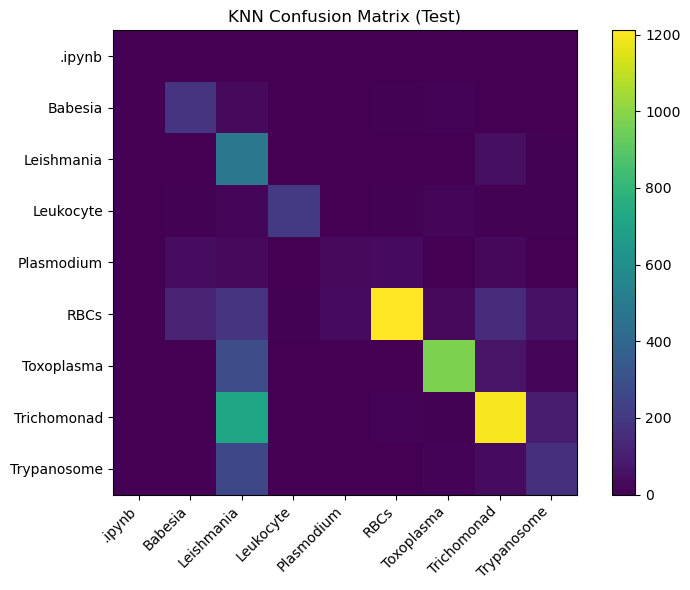

In [13]:
#9) Confusion matrix heatmap + per-class F1 bar
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation="nearest", cmap="viridis")
plt.title("KNN Confusion Matrix (Test)")
plt.colorbar()
plt.xticks(range(C), classes_str, rotation=45, ha="right")
plt.yticks(range(C), classes_str)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/confusion_matrix.png", dpi=200)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(classes_str, list(f1s))
plt.title("Per-class F1 (Test)")
plt.xticks(rotation=45, ha="right"); plt.ylim(0,1.05)
plt.tight_layout()
plt.savefig(f"{OUTDIR}/per_class_f1.png", dpi=200)
plt.show()

PermissionError: [Errno 13] Permission denied: '/root//roc_curves.png'

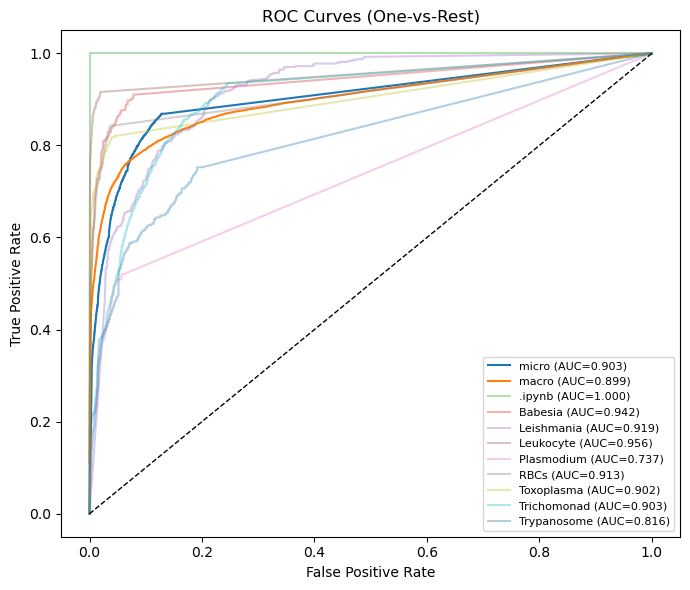

In [14]:
#10) ROC curves (micro, macro, per-class)
proba = best.predict_proba(Xte)                 # (N, C)
Y_true_bin = label_binarize(yte, classes=list(range(C)))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(C):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_true_bin.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(C)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(C):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= C
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7,6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro (AUC={roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], label=f"macro (AUC={roc_auc['macro']:.3f})")
for i, cls in enumerate(classes_str):
    plt.plot(fpr[i], tpr[i], alpha=0.35, label=f"{cls} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(fontsize=8, loc="lower right")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/roc_curves.png", dpi=200); plt.show()

PermissionError: [Errno 13] Permission denied: '/root//pr_curves.png'

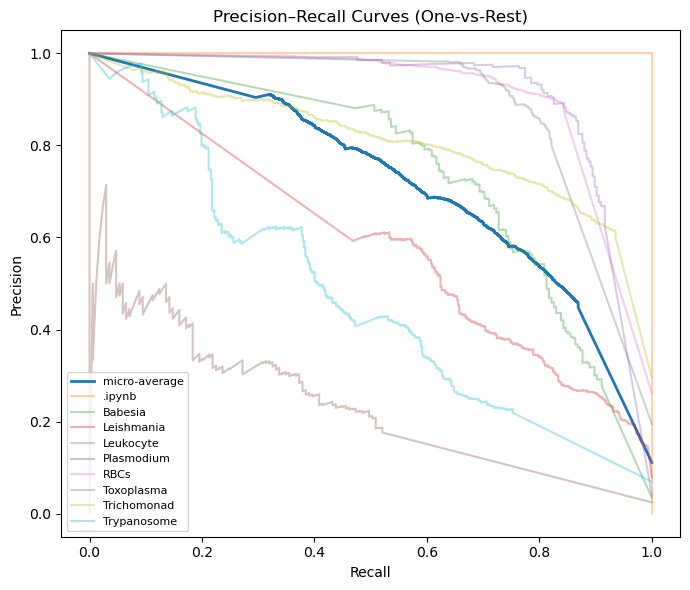

In [15]:
#11) Precision–Recall curves (micro + per-class)
prec_c, rec_c = {}, {}
for i in range(C):
    prec_c[i], rec_c[i], _ = precision_recall_curve(Y_true_bin[:, i], proba[:, i])

prec_micro, rec_micro, _ = precision_recall_curve(Y_true_bin.ravel(), proba.ravel())

plt.figure(figsize=(7,6))
plt.plot(rec_micro, prec_micro, label="micro-average", lw=2)
for i, cls in enumerate(classes_str):
    plt.plot(rec_c[i], prec_c[i], alpha=0.35, label=f"{cls}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves (One-vs-Rest)")
plt.legend(fontsize=8, loc="lower left")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/pr_curves.png", dpi=200); plt.show()

In [16]:
#12) t-SNE of scaled features (colored by class)
# Subsample for speed
max_points = 3000
idx = np.arange(len(Xte))
if len(idx) > max_points:
    take_per_class = max(50, max_points // C)
    chosen = []
    yte_arr = np.array(yte)
    for c in range(C):
        ci = np.where(yte_arr == c)[0]
        take = min(len(ci), take_per_class)
        if take > 0: chosen.extend(np.random.choice(ci, size=take, replace=False))
    idx = np.array(chosen)

scaler = best.named_steps["scaler"]
Zvis = scaler.transform(Xte[idx])
yvis = np.array(yte)[idx]

tsne = TSNE(n_components=2, init="pca", random_state=SEED, perplexity=30, learning_rate="auto")
emb = tsne.fit_transform(Zvis)

plt.figure(figsize=(7,6))
for i, cls in enumerate(classes_str):
    pts = emb[yvis == i]
    plt.scatter(pts[:,0], pts[:,1], s=10, alpha=0.7, label=cls)
plt.title("t-SNE of Test Features (HOG+LBP+Color, scaled)")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/tsne_test.png", dpi=200, bbox_inches="tigh

SyntaxError: unterminated string literal (detected at line 28) (2139239120.py, line 28)

In [17]:
#13) Robustness on validation (Δ macro-F1) + bar chart
def down_up(im, s=0.5):
    small = transform.resize(im, (max(1,int(im.shape[0]*s)), max(1,int(im.shape[1]*s))), anti_aliasing=True)
    return transform.resize(small, IMG_SIZE, anti_aliasing=True)
def blur(im, sigma=1.2): return filters.gaussian(im, sigma=sigma, preserve_range=True)
def gnoise(im, var=0.01): return util.random_noise(im, mode="gaussian", var=var, clip=True)
def pnoise(im): return util.random_noise(im, mode="poisson", clip=True)
def jpeg(im, q=40):
    im8 = (np.clip(im,0,1)*255).astype(np.uint8)
    bio = io.BytesIO(); Image.fromarray(im8).save(bio, format="JPEG", quality=q); bio.seek(0)
    return np.asarray(Image.open(bio)).astype(np.float32)/255.0

def eval_deg(name, fn):
    Xva_d = feats_from_paths(X_val, tform=fn)
    yva_d = y_val[:len(Xva_d)]
    f1c = f1_score(yva, best.predict(Xva), average="macro")
    f1d = f1_score(yva_d, best.predict(Xva_d), average="macro")
    return {"name":name,"clean":float(f1c),"degraded":float(f1d),"delta":float(f1d-f1c)}

rob = [
    eval_deg("DownUp x0.5", lambda im: down_up(im,0.5)),
    eval_deg("Gaussian blur σ=1.2", lambda im: blur(im,1.2)),
    eval_deg("Gaussian noise var=0.01", lambda im: gnoise(im,0.01)),
    eval_deg("Poisson noise", pnoise),
    eval_deg("JPEG Q=40", lambda im: jpeg(im,40)),
]
with open(f"{OUTDIR}/robustness_val.json","w") as f: json.dump(rob, f, indent=2)

names = [r["name"] for r in rob]; deltas = [r["delta"] for r in rob]
plt.figure(figsize=(7,4))
plt.barh(names, deltas); plt.axvline(0, color="k", lw=1)
plt.title("Robustness (Δ macro-F1 vs clean) on Validation")
plt.xlabel("Delta macro-F1")
plt.tight_layout(); plt.savefig(f"{OUTDIR}/robustness_bar.png", dpi=200); plt.show()

Features: 100%|██████████| 6861/6861 [08:57<00:00, 12.78it/s]


PermissionError: [Errno 13] Permission denied: '/root//robustness_val.json'

In [ ]:
print("All outputs in:", OUTDIR)
for f in sorted(os.listdir(OUTDIR)):
    print(" -", f)

PermissionError: [Errno 13] Permission denied: '/root//tsne_test.png'

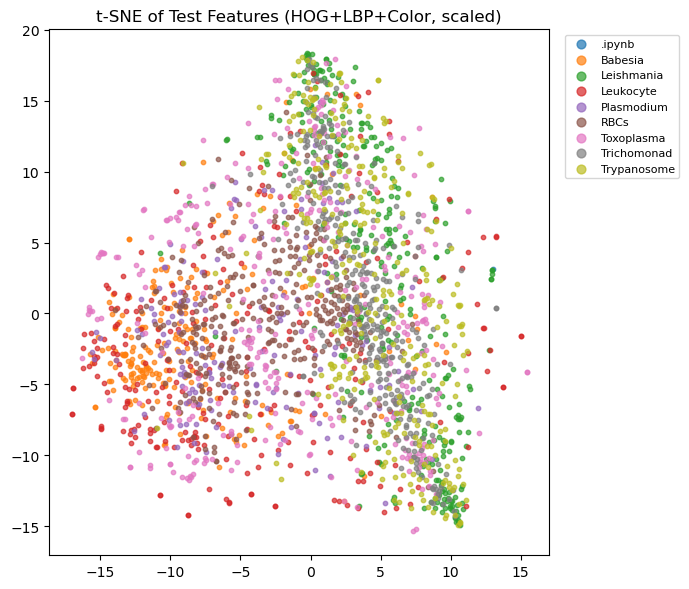

In [19]:
# 12) t-SNE of scaled features (colored by class)
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Subsample for speed
max_points = 3000
idx = np.arange(len(Xte))
if len(idx) > max_points:
    take_per_class = max(50, max_points // C)
    chosen = []
    yte_arr = np.array(yte)
    for c in range(C):
        ci = np.where(yte_arr == c)[0]
        take = min(len(ci), take_per_class)
        if take > 0:
            chosen.extend(np.random.choice(ci, size=take, replace=False))
    idx = np.array(chosen)

# Scale features
scaler = best.named_steps["scaler"]
Zvis = scaler.transform(Xte[idx])
yvis = np.array(yte)[idx]

# t-SNE projection
tsne = TSNE(n_components=2, init="pca", random_state=SEED,
            perplexity=30, learning_rate="auto")
emb = tsne.fit_transform(Zvis)

# Plot
plt.figure(figsize=(7,6))
for i, cls in enumerate(classes_str):
    pts = emb[yvis == i]
    plt.scatter(pts[:,0], pts[:,1], s=10, alpha=0.7, label=cls)

plt.title("t-SNE of Test Features (HOG+LBP+Color, scaled)")
plt.legend(markerscale=2, fontsize=8, bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{OUTDIR}/tsne_test.png", dpi=200, bbox_inches="tight")
plt.show()

